# x,y 좌표 추출

In [2]:
import cv2
import numpy as np

# 1. 이미지를 읽어옵니다.
image = cv2.imread('field_image.png')

# 이미지의 크기를 얻습니다. shape는 (height, width, channels)로 구성됩니다.
height, width, channels = image.shape

# 전체 픽셀 수를 계산합니다.
total_pixels = height * width

# 2. 이미지를 그레이스케일로 변환합니다.
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 3. 이진화(binarization)를 수행하여 잡초가 있는 부분과 없는 부분을 구분합니다.
# 임계값은 127로 설정하여, 명암값이 70보다 큰 부분을 잡초가 있는 부분으로 간주합니다.
_, binary_image = cv2.threshold(gray_image, 70, 255, cv2.THRESH_BINARY)

# 4. 잡초가 있는 부분의 픽셀값을 추출(RGB)합니다.
# 잡초가 있는 부분의 픽셀 값은 binary_image가 255인 부분의 픽셀 값입니다.
# weed_pixels = image[binary_image == 255]

# 4. 잡초가 있는 픽셀의 좌표를 추출합니다.
weed_coordinates = np.column_stack(np.where(binary_image == 255))

# 5. 추출한 좌표를 텍스트 파일로 저장합니다.
np.savetxt('weed_coordinates.txt', weed_coordinates, fmt='%d', delimiter=',', header='y,x', comments='')

# 추출한 잡초 부분의 픽셀값을 출력합니다.
# print(weed_pixels)

# 필요한 경우, 추출한 잡초 부분을 별도의 이미지로 저장할 수 있습니다.
weed_image = np.zeros_like(image)
weed_image[binary_image == 255] = image[binary_image == 255]

cv2.imwrite('gray_image.jpg', gray_image)
cv2.imwrite('weed_image.jpg', weed_image)



True

# z좌표 설정

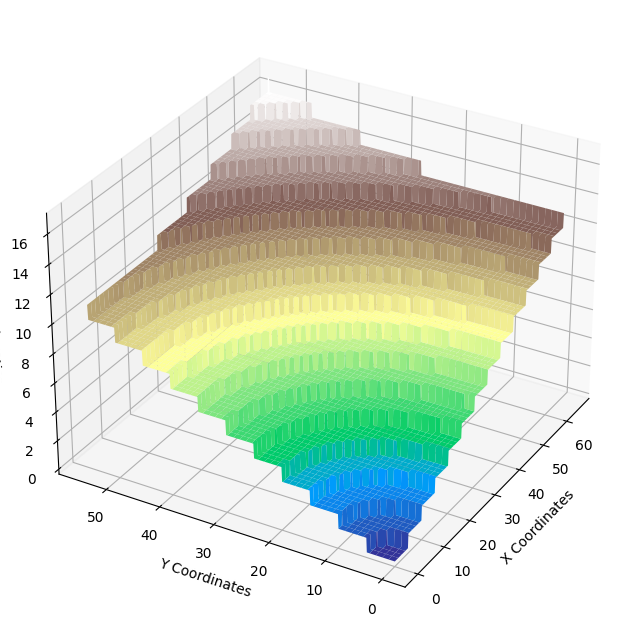

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import noise

def terraced_field_with_noise(x, y, N ,M ,scale=0.1, height_scale=5, noise_scale=1.5):
    # 노이즈를 생성하여 지형에 적용합니다.
    base_noise = noise.pnoise2(scale * N, scale * M) * noise_scale
    # 계단식 농지의 높이를 계산합니다.
    height_filter = 1
    terrace_height = np.floor((np.sqrt(x**2 + y**2) + base_noise) / height_scale) * height_filter
    return terrace_height

N = 650//10
M  = 550//10

# 그리드 생성
x = np.linspace(0, N, N*10)
y = np.linspace(0, M, M*10)
x, y = np.meshgrid(x, y)
z = terraced_field_with_noise(x, y, 400, 400)

# 플롯 설정
fig = plt.figure(figsize=(12, 8))  # 여기서 그래프의 크기를 12x8 인치로 설정합니다.
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='terrain', edgecolor='none')

# 축 레이블 설정
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')
ax.set_zlabel('Elevation')

# 그래프를 45도 회전
ax.view_init(elev=30, azim=-150)  # elev는 30도로 설정, azim은 45도로 설정

# 표시
plt.show()


import pandas as pd

xyz = {"x": [], "y": [], "z": []}
for i in range(len(z[0])):
    for j in range(len(z)):
        xyz["x"].append(i)
        xyz['y'].append(j)
        xyz['z'].append(z[j,i] * 10)

# 전체 좌표
P = pd.DataFrame(xyz)
P.to_csv("xyz.csv")

# Set covering

In [29]:
import gurobipy as gp
from gurobipy import GRB
import math

file_path = "weed_coordinates.txt"
data = pd.read_csv(file_path)
coordinates = pd.read_csv("xyz.csv",  index_col=0)

_z = []
for i in data.itertuples():
    cond = (coordinates['x'] == i.x) & (coordinates['y'] == i.y)
    item = coordinates.loc[cond, "z"]
    if len(item) == 0:
        v = 140
    else:
        v = float(item)
    _z.append(v)

data["z"] = _z

_points = [(row//10, col//10, hei//10) for row, col, hei in zip(data['x'], data['y'], data['z'])]
points = pd.DataFrame(_points, columns=['x', 'y', 'z'])

/var/folders/3l/z2_cjhyd20v1_yppby93tmnh0000gn/T/ipykernel_26634/491912261.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  v = float(item)


In [38]:
iteration = [5-1,6-1]
_row = [0,100,200,300,400,500]
_col = [0,100,200,300,400,500,600]

drone_angle = math.radians(120)
t = math.tan(drone_angle / 2)

## 상공 10m~50m
def calc_range(height):
    # 방사각 120도 일때 반지름 범위

    drone_height = [height+1, height+10]
    r = [h * math.tan(drone_angle / 2) for h in drone_height]

    return r[0], r[-1]

_, r0 = calc_range(20)
r1, r2 = calc_range(20)

def solve_sc(row_index, col_index):
    solution = {"x": [], "y": [], "z": []}
    inf = dict()
    
    con1 = (_row[row_index]<= data['y']) & (data['y']<=_row[row_index+1])
    con2 = (_col[col_index]<= data['x']) & (data['x']<=_col[col_index+1])
    df = data[con1 & con2]
    # df['row'] = df['row'] - 100 * row_index
    df['y'] = [_r - 100 * row_index for _r in df['y'].values]
    df['x'] = [_c - 100 * col_index for _c in df['x'].values]

    con1 = (_row[row_index]<= coordinates['y']) & (coordinates['y']<=_row[row_index+1])
    con2 = (_col[col_index]<= coordinates['x']) & (coordinates['x']<=_col[col_index+1])
    space = coordinates[con1 & con2]


    # 'row'와 'col' 열을 이용하여 튜플 리스트 생성
    required_pixels = [(x, y, z) for x, y, z in zip(df['x'], df['y'], df['z'])]

    # 데이터/파라미터 초기화
    N = 100  # 그리드의 가로 크기
    M = 100  # 그리드의 세로 크기
    J = range(N * M)  # 전체 그리드 픽셀 집합
    I = [y * N + x for (x, y, z) in required_pixels]
    Zj = [z for z in space['z']]
    Zi = [z for (x,y,z) in required_pixels]


    # 높이 고려 안했을 때의 최대 거리
    max_distance = r0

    # 제약 조건을 추가하기 전에, 각 i 픽셀에 대해 허용 가능한 j 픽셀만 필터링
    nearby_j = {i: [j for j in J if math.sqrt(((divmod(j, N)[0]-divmod(i, N)[0])**2 + 
                                            (divmod(j, N)[1]-divmod(i, N)[1])**2)) <= max_distance] for i in I}
            
    # 모델 생성
    model = gp.Model("pesticide_application")

    # 변수 생성
    S = model.addVars(J, vtype=GRB.BINARY, name="S")  # 살포 지점 j가 선택되었는지를 나타내는 이진 변수
    C = model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")  # 지점 j에 의해서 지점 i가 커버될 수 있는지를 나타내는 이진 변수
    a = model.addVars(J, vtype=GRB.CONTINUOUS, name="a")
    q = model.addVars(J, vtype=GRB.CONTINUOUS, name="q")

    # 목적 함수 설정: 최소한의 살포 지점 선택
    model.setObjective(gp.quicksum(S[j] for j in J), sense=GRB.MINIMIZE)

    # 제약 조건 추가
    index = 0
    for i in I:
        xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
        zi = Zi[index]
        index += 1
        for j in nearby_j[i]:

            
            xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표
            zj = Zj[j]
            dist = math.sqrt(((xj-xi)**2 + (yj-yi)**2)) + t * (zi-zj)  # 두 좌표간의 거리

            # i 픽셀이 j 픽셀에 의해 커버될 수 있는지에 대한 제약 조건                      
            model.addConstr(dist * C[i,j]<=a[j])
            # model.addConstr(r1 <= a[j])
            model.addConstr(a[j]<= r2)
            model.addConstr(S[j] >= C[i, j])

            # model.addConstr(q[j] == a[j] + t * (zi-zj))

    # 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
    for i in I:
        model.addConstr(gp.quicksum(C[i, j] for j in nearby_j[i]) >= 1)

    # 모델 최적화
    model.optimize()


    # # 두 번째 모델 생성
    # second_model = gp.Model("second_model")

    # # 첫 번째 모델의 변수와 제약 조건을 복사
    # S2 = second_model.addVars(J, vtype=GRB.BINARY, name="S")
    # C2 = second_model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")
    # a2 = second_model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

    # # 첫 번째 모델의 솔루션 고정
    # if model.status == GRB.OPTIMAL:
    #     for j in J:
    #         S[j].start = S[j].x
    #         a[j].start = a[j].x
    #     for i, j in C.keys():
    #         C[i, j].start = C[i, j].x

    #     # 첫 번째 모델의 솔루션을 두 번째 모델에 고정
    #     for j in J:
    #         S2[j].lb = S[j].x
    #         S2[j].ub = S[j].x

    #     for i, j in C.keys():
    #         C2[i, j].lb = C[i, j].x
    #         C2[i, j].ub = C[i, j].x
    # else:
    #     inf["row_index"] = row_index
    #     inf['col_index'] = col_index

    # # 두 번째 모델의 목적 함수 설정
    # second_model.setObjective(gp.quicksum(a2[j] for j in J), sense=GRB.MINIMIZE)

    # # 제약 조건 추가
    # index = 0
    # for i in I:
    #     xi, yi = divmod(i, N)
    #     zi = Zi[index]
    #     index += 1
    #     for j in nearby_j[i]:
    #         xj, yj = divmod(j, N)
    #         dist = math.sqrt((xj - xi)**2 + (yj - yi)**2) + t * (zi)
    #         # second_model.addConstr(r1 <= a2[j])
    #         second_model.addConstr(dist * C2[i, j] <= a2[j])
    #         second_model.addConstr(a2[j] <= r2)

    # # 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
    # for i in I:
    #     second_model.addConstr(gp.quicksum(C2[i, j] for j in nearby_j[i]) >= 1)

    # # 두 번째 모델 최적화
    # second_model.optimize()

    # # 최적해 출력 및 시각화 준비
    # if second_model.status == GRB.OPTIMAL:
    #     # solution = {v.varName: v.x for v in model.getVars() if v.x != 0}

    #     # 시각화 코드
    #     fig, ax = plt.subplots(figsize=(12, 10))

    #     # 농약 살포가 필요한 픽셀
    #     for i in I:
    #         xi, yi = divmod(i, N)
    #         ax.scatter(xi, yi, color='red', marker='s', s=10)

    #     # 선택된 살포 지점 및 커버 범위
    #     for j in J:
    #         if S[j].x > 0.5:
    #             xj, yj = divmod(j, N)
    #             aj = a2[j].x
    #             rect = plt.Circle((xj, yj), radius=aj, color='blue', fill=False, linestyle='dotted')
    #             ax.add_artist(rect)
    #             ax.scatter(xj, yj, color='blue', marker='o', s=10)

    #             solution['x'].append(xj + row_index * 100)
    #             solution['y'].append(yj + col_index * 100)
    #             solution['z'].append(Zj[j])

    #     plt.xlim(-1, N)
    #     plt.ylim(-1, M)
    #     plt.gca().set_aspect('equal', adjustable='box')
    #     plt.grid(True)
    #     plt.title('Pesticide Application Optimization with Varying Z Range')
    #     plt.xlabel('X Coordinate')
    #     plt.ylabel('Y Coordinate')
    #     plt.savefig(f"sc{row_index}_{col_index}")
    # else:
    #     print("No optimal solution found.")

    # return solution, inf


    # 최적해 출력 및 시각화 준비
    if model.status == GRB.OPTIMAL:
        # solution = {v.varName: v.x for v in model.getVars() if v.x != 0}

        # 시각화 코드
        fig, ax = plt.subplots(figsize=(12, 10))

        # 농약 살포가 필요한 픽셀
        for i in I:
            xi, yi = divmod(i, N)
            ax.scatter(xi, yi, color='red', marker='s', s=10)

        # 선택된 살포 지점 및 커버 범위
        for j in J:
            if S[j].x > 0.5:
                xj, yj = divmod(j, N)
                aj = a[j].x
                rect = plt.Circle((xj, yj), radius=aj, color='blue', fill=False, linestyle='dotted')
                ax.add_artist(rect)
                ax.scatter(xj, yj, color='blue', marker='o', s=10)

                solution['x'].append(xj + row_index * 100)
                solution['y'].append(yj + col_index * 100)
                solution['z'].append(Zj[j])

        plt.xlim(-1, N)
        plt.ylim(-1, M)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid(True)
        plt.title('Pesticide Application Optimization with Varying Z Range')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.savefig(f"sc{row_index}_{col_index}")
    else:
        inf["row_index"] = row_index
        inf['col_index'] = col_index
        print("No optimal solution found.")

    return solution, inf


/var/folders/3l/z2_cjhyd20v1_yppby93tmnh0000gn/T/ipykernel_26634/3999970208.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = [_r - 100 * row_index for _r in df['y'].values]
/var/folders/3l/z2_cjhyd20v1_yppby93tmnh0000gn/T/ipykernel_26634/3999970208.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] = [_c - 100 * col_index for _c in df['x'].values]


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7019233 rows, 2369571 columns and 14037236 nonzeros
Model fingerprint: 0x12ef657c
Variable types: 20000 continuous, 2349571 integer (2349571 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 408.0000000
Presolve removed 2768776 rows and 65146 columns (presolve time = 5s) ...
Presolve removed 4721112 rows and 65146 columns (presolve time = 12s) ...
Presolve removed 4795966 rows and 140000 columns (presolve time = 15s) ...
Presolve removed 4945966 rows and 290000 columns (presolve time = 20s) ...
Presolve removed 5095966 rows and 440000 columns (presolve time = 25s) ...
Presolve removed 5245966 rows and 590000 columns (presolv

KeyboardInterrupt: 

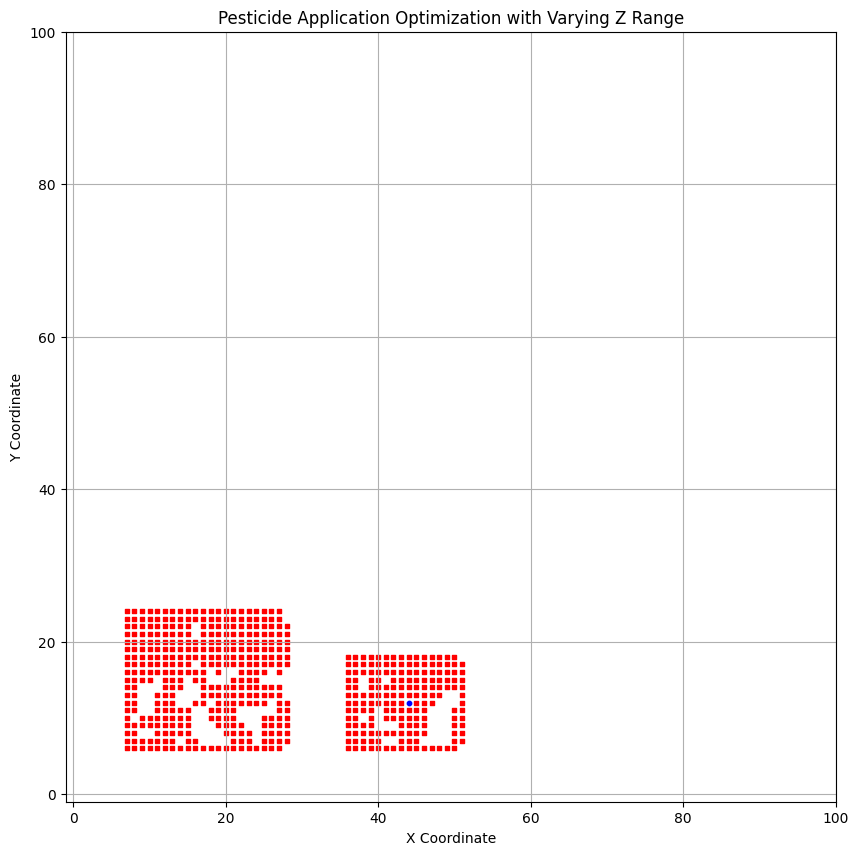

In [39]:
iteration = [5,6]
_row = [0,100,200,300,400,500]
_col = [0,100,200,300,400,500,600]

solutions = []
infeasible = []

for row_index in range(iteration[0]):
    for col_index in range(iteration[1]):
        sol, inf = solve_sc(row_index, col_index)
        solutions.append(sol)
        infeasible.append(inf)

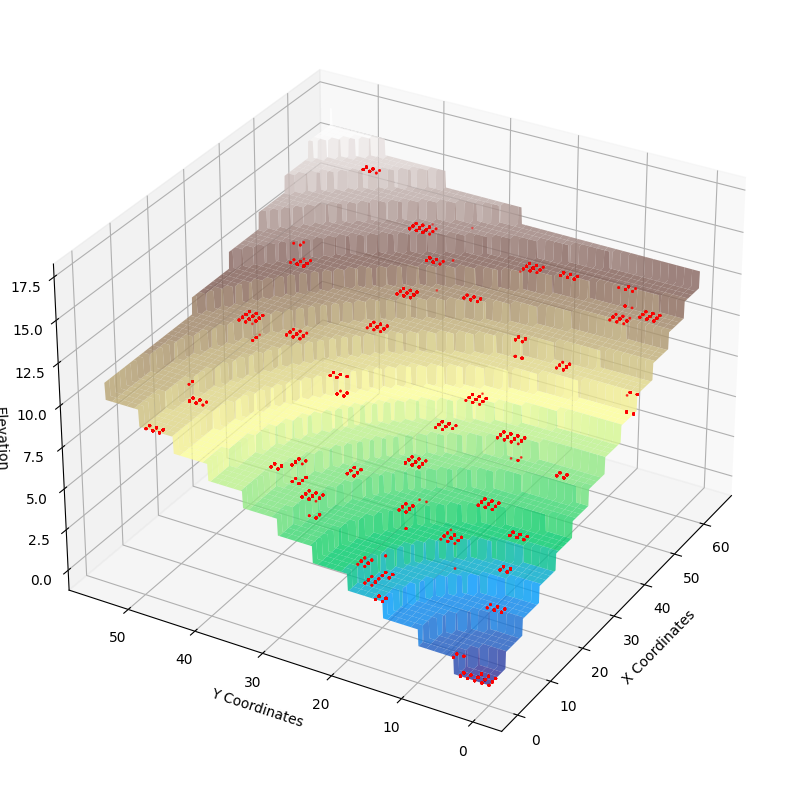

In [36]:
N = 650//10
M  = 550//10

# 그리드 생성
x = np.linspace(0, N, N*10)
y = np.linspace(0, M, M*10)
x, y = np.meshgrid(x, y)
z = terraced_field_with_noise(x, y, 400, 400)

# 플롯 설정
fig = plt.figure(figsize=(15, 10))  # 여기서 그래프의 크기를 12x8 인치로 설정합니다.
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='terrain', edgecolor='none', alpha = 0.8)

# 축 레이블 설정
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')
ax.set_zlabel('Elevation')

# 그래프를 45도 회전
ax.view_init(elev=30, azim=-150)  # elev는 30도로 설정, azim은 45도로 설정

# 점 찍기
ax.scatter(points["x"], points["y"], points["z"], color='r', s=1)  # s는 점의 크기

# 표시
plt.show()



In [ ]:
N = 100//10
M  = 100//10

# 그리드 생성
x = np.linspace(0, N, N*10)
y = np.linspace(0, M, M*10)
x, y = np.meshgrid(x, y)
z = terraced_field_with_noise(x, y, 400, 400)

# 플롯 설정
fig = plt.figure(figsize=(15, 10))  # 여기서 그래프의 크기를 12x8 인치로 설정합니다.
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='terrain', edgecolor='none')

# 축 레이블 설정
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')
ax.set_zlabel('Elevation')

# 그래프를 45도 회전
ax.view_init(elev=30, azim=-150)  # elev는 30도로 설정, azim은 45도로 설정

# 점 찍기
ax.scatter(points["x"], points["y"], points["z"], color='r', s=1)  # s는 점의 크기

# 표시
plt.show()

